In [1]:
import sys
import os

# Adjust the path to point to the 'src' directory relative to your notebook
sys.path.append(os.path.abspath("../src"))

import generations
import search_space
import data_preprocessing as dp

import baseline_models as bm
from instance_sampling import create_dataloaders

In [2]:
# DATA_ID = 41143
DATA_ID = 31
# DATA_ID = 54
X_train, y_train, X_val, y_val, X_test, y_test = dp.get_preprocessed_data(
        dataset_id=DATA_ID, scaling=True, random_seed=13, return_as='tensor', task_type='classification')

Trying with Dataset: credit-g
Categorical features detected: ['checking_status', 'credit_history', 'purpose', 'savings_status', 'employment', 'personal_status', 'other_parties', 'property_magnitude', 'other_payment_plans', 'housing', 'job', 'own_telephone', 'foreign_worker']
Class column is not numeric. Applying LabelEncoder.
Data loaded successfully! Format: tensor
Training data shape: torch.Size([640, 20])
y_training data shape: torch.Size([640])


In [3]:
baseline_metric, time_budget, scoreboard = bm.get_models_and_baseline_metric(X_train, y_train, n_models=20)
print("Baseline metric:", baseline_metric)
print("Time budget for baseline models:", time_budget)
display(scoreboard)
time_budget = time_budget * 3 # Since NN models require more time, the time budget gets tripled
# baseline_metric = 0.5

Baseline metric: 0.7469
Time budget for baseline models: 179.68272352218628


,pipeline,accuracy
1,"((DecisionTreeClassifier(max_features='sqrt', ...",0.7656
82,(RandomForestClassifier(criterion=np.str_('gin...,0.7656
100,"(RandomForestClassifier(bootstrap=False, crite...",0.7625
101,(RandomForestClassifier(criterion=np.str_('gin...,0.7609
46,(RandomForestClassifier(criterion=np.str_('ent...,0.7594
76,"(RandomForestClassifier(bootstrap=False, crite...",0.7578
22,"(VarianceThreshold(), RandomForestClassifier())",0.7578
118,"(RandomForestClassifier(bootstrap=False, crite...",0.7562
85,"(RandomForestClassifier(bootstrap=False, crite...",0.7562
44,"(RandomForestClassifier(bootstrap=False, crite...",0.7547


In [4]:
input_size, output_size = dp.get_tensor_sizes(X_train, y_train)

In [5]:
search_space = search_space.SearchSpace(input_size=input_size, output_size=output_size)

In [6]:
N_INDIVIDUALS = 400 # amount of architectures to be evaluated as a starting point
N_EPOCHS = 200
percentile_drop = 5 # drop the worst 5% of architectures after first epoch

In [7]:
# The generation is created given the search space and the number of individuals.
generation = generations.Generation(search_space, N_INDIVIDUALS, starting_instances=1000)

In [8]:
generation.run_ebe(epochs=N_EPOCHS,
                    X_train=X_train,
                    y_train=y_train,
                    X_val=X_val,
                    y_val=y_val, 
                    percentile_drop=percentile_drop,
                    baseline_metric=baseline_metric, 
                    time_budget=time_budget,
                    epoch_threshold=3
                    )

Epoch 1/200 - Running EBE
Epoch 2/200 - Running EBE
Epoch 3/200 - Running EBE
Epoch 4/200 - Running EBE
Epoch 5/200 - Running EBE
Epoch 6/200 - Running EBE
Epoch 7/200 - Running EBE
Epoch 8/200 - Running EBE
Epoch 9/200 - Running EBE
Only 6 models left, stopping EBE.


In [9]:
results_df = generation.return_df()
display(results_df)

,hidden_layers,activation_fn,dropout_rate,optimizer_type,learning_rate,weight_decay,momentum,batch_size,use_skip_connections,initializer,...,train_loss,train_acc,val_loss,val_acc,efforts,n_instances,fcst_accuracy,higher_than_baseline,final_val_acc,final_val_loss
0,"[339, 16, 93, 42, 341, 188]",<class 'torch.nn.modules.activation.ReLU'>,0.0,<class 'torch.optim.rmsprop.RMSprop'>,0.001512,0.00010,None,64,False,kaiming_uniform,...,"[1.4407153308391571, 0.5339824944734574, 0.476...","[0.653125, 0.728125, 0.7703125, 0.7890625, 0.8...","[0.6260004758834838, 0.5706395745277405, 0.510...","[0.60625, 0.71875, 0.7375, 0.73125, 0.7125, 0....","[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]","[640, 640, 640, 640, 640, 640, 640, 640, 640]",0.788064,True,0.76250,0.594183
1,"[53, 155, 388, 450, 339, 131, 409]",<class 'torch.nn.modules.activation.ReLU'>,0.1,<class 'torch.optim.rmsprop.RMSprop'>,0.000246,0.00000,None,32,True,xavier_normal,...,"[0.6076622039079667, 0.5449529156088829, 0.520...","[0.6984375, 0.7203125, 0.7390625, 0.7765625, 0...","[0.647019898891449, 0.6062820792198181, 0.6114...","[0.6, 0.675, 0.66875, 0.7, 0.7, 0.75625, 0.775...","[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]","[640, 640, 640, 640, 640, 640, 640, 640, 640]",0.764467,True,0.73125,0.615840
2,"[330, 234, 58, 287, 369, 285, 144, 199, 303, 204]",<class 'torch.nn.modules.activation.ELU'>,0.0,<class 'torch.optim.adamw.AdamW'>,0.000119,0.00100,None,512,False,kaiming_uniform,...,"[1.2181602597236634, 0.6562166333198547, 0.620...","[0.365625, 0.6421875, 0.7203125, 0.728125, 0.7...","[0.7881067991256714, 0.8565453290939331, 0.900...","[0.51875, 0.60625, 0.60625, 0.61875, 0.66875, ...","[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]","[640, 640, 640, 640, 640, 640, 640, 640, 640]",0.762775,True,0.74375,0.615312
3,"[298, 383, 126, 122, 467, 41, 494, 231]",<class 'torch.nn.modules.activation.ReLU'>,0.1,<class 'torch.optim.rmsprop.RMSprop'>,0.000409,0.00001,None,32,True,kaiming_uniform,...,"[0.7245975136756897, 0.5458137661218643, 0.522...","[0.70625, 0.728125, 0.70625, 0.7296875, 0.7453...","[0.6471633017063141, 0.6758693039417267, 0.569...","[0.6, 0.63125, 0.7, 0.70625, 0.73125, 0.6875, ...","[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]","[640, 640, 640, 640, 640, 640, 640, 640, 640]",0.756378,True,0.72500,0.643932
4,"[497, 435, 41, 99, 455, 337]",<class 'torch.nn.modules.activation.LeakyReLU'>,0.1,<class 'torch.optim.rmsprop.RMSprop'>,0.000266,0.00010,None,32,False,kaiming_uniform,...,"[0.7006822526454926, 0.5356596872210503, 0.485...","[0.6953125, 0.740625, 0.7546875, 0.7796875, 0....","[0.6382931113243103, 0.582068657875061, 0.5920...","[0.625, 0.63125, 0.675, 0.66875, 0.66875, 0.70...","[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]","[640, 640, 640, 640, 640, 640, 640, 640, 640]",0.716793,False,0.71875,0.632634
5,"[86, 62]",<class 'torch.nn.modules.activation.ReLU'>,0.0,<class 'torch.optim.rmsprop.RMSprop'>,0.006535,0.00001,None,64,False,xavier_normal,...,"[0.6992147117853165, 0.5010377943515778, 0.426...","[0.70625, 0.7375, 0.7890625, 0.8125, 0.84375, ...","[0.5535701632499694, 0.5995912551879883, 0.695...","[0.725, 0.6875, 0.6625, 0.7375, 0.69375, 0.693...","[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]","[640, 640, 640, 640, 640, 640, 640, 640, 640]",0.704944,False,0.72500,0.745944


In [10]:
# import ast
# results_df["val_acc"] = results_df["val_acc"].apply(ast.literal_eval)
# results_df["efforts"] = results_df["efforts"].apply(ast.literal_eval)

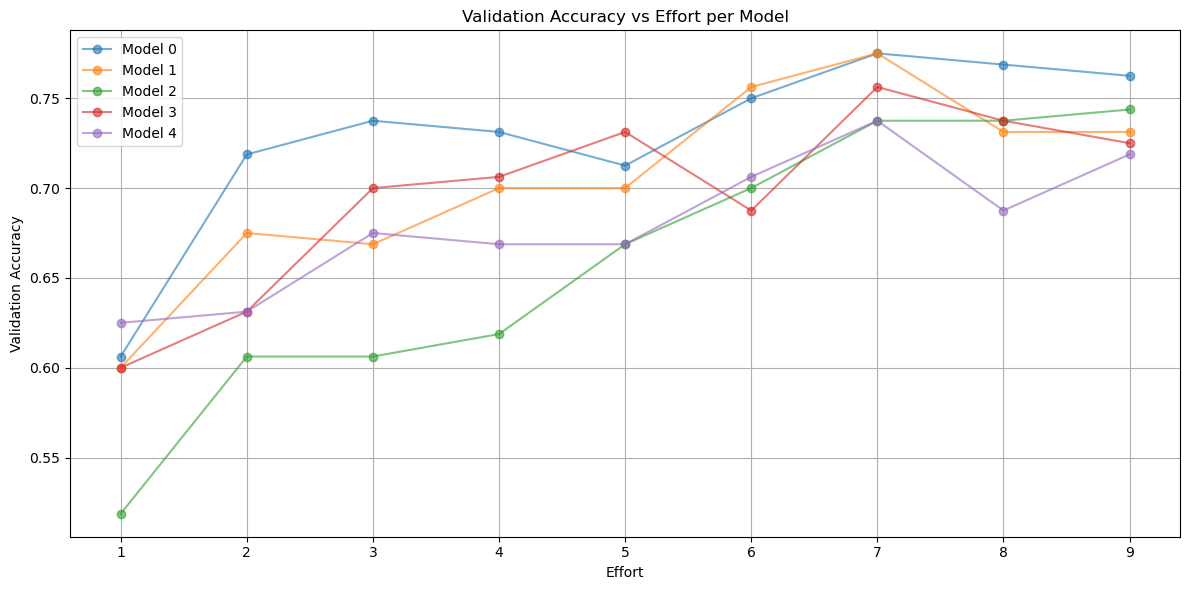

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for idx, row in results_df.head().iterrows():
    efforts = row["efforts"]
    accs = row["val_acc"]
    plt.plot(efforts, accs, label=f'Model {idx}', marker='o', alpha=0.6)
plt.xlabel("Effort")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy vs Effort per Model")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [12]:
# Train till the end the best model
best_model = generation.get_best_model()

In [13]:
from instance_sampling import create_dataloaders

batch_size = int(results_df.loc[0, 'batch_size']) # batch size for training the model
# For training a model, DataLoader is needed
train_loader = create_dataloaders(X=X_train, y=y_train, 
                       batch_size=batch_size)
val_loader = create_dataloaders(X=X_val, y=y_val, 
                       batch_size=batch_size)
test_loader = create_dataloaders(X=X_test, y=y_test, 
                       batch_size=batch_size)

In [14]:
best_train_loss, best_train_acc, best_val_loss, best_val_acc = best_model.es_train(train_loader=train_loader, val_loader=val_loader,
                    es_patience=100, # epochs without improvement
                    max_epochs=1000, # cap for epochs
                    verbose=True, # print training progress
)

test_loss, test_accuracy = best_model.evaluate(test_loader)
print(f"Best model training loss: {best_train_loss:.4f}, training accuracy: {best_train_acc:.4f}")
print(f"Best model validation loss: {best_val_loss:.4f}, validation accuracy: {best_val_acc:.4f}")
print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_accuracy:.4f}")

New best acc found: 0.7500
Epoch 1: Train Loss=0.2495, Train Acc=0.9016, Val Loss=0.7899, Val Acc=0.7500
Epoch 2: Train Loss=0.2004, Train Acc=0.9156, Val Loss=0.7625, Val Acc=0.7188
Epoch 3: Train Loss=0.1783, Train Acc=0.9266, Val Loss=0.9844, Val Acc=0.7125
New best acc found: 0.7562
Epoch 4: Train Loss=0.1769, Train Acc=0.9328, Val Loss=0.8889, Val Acc=0.7562
Epoch 5: Train Loss=0.1132, Train Acc=0.9688, Val Loss=1.0977, Val Acc=0.7438
Epoch 6: Train Loss=0.1118, Train Acc=0.9641, Val Loss=1.1858, Val Acc=0.7188
Epoch 7: Train Loss=0.1076, Train Acc=0.9578, Val Loss=1.0321, Val Acc=0.7500
Epoch 8: Train Loss=0.2252, Train Acc=0.9109, Val Loss=0.9526, Val Acc=0.6750
Epoch 9: Train Loss=0.1158, Train Acc=0.9703, Val Loss=1.1552, Val Acc=0.7188
Epoch 10: Train Loss=0.0757, Train Acc=0.9750, Val Loss=1.4845, Val Acc=0.7312
Epoch 11: Train Loss=0.0545, Train Acc=0.9859, Val Loss=1.5007, Val Acc=0.7438
Epoch 12: Train Loss=0.0455, Train Acc=0.9891, Val Loss=1.4957, Val Acc=0.7188
Epoch 1

In [15]:
results_df.loc[0, 'fcst_accuracy']

np.float64(0.7880643557092375)

In [20]:

# Print the report
print('Baseline metric found by NaiveAutoMl:', baseline_metric)
print('True validation accuracy of the best model:', best_val_acc)
print('Time budget used in NaiveAutoML:', time_budget / 3)
print('Time budget for neural models (3x Naive):', time_budget)
print('_' * 20)
print('Best neural model forecasted accuracy:', results_df.loc[0, 'fcst_accuracy'])
print('Best neural model final (true) validation accuracy:', best_val_acc)
if best_val_acc < results_df.loc[0, 'fcst_accuracy']:
    print("The best model's final validation accuracy is less than the forecasted accuracy.")
else:
    print("The best model's final validation accuracy is greater or equal than the forecasted accuracy.")

if best_val_acc > baseline_metric:
    print("The best model true validation accuracy outperforms the baseline metric")

else:
    print("The best model true validation accuracy does not outperform the baseline metric")

    


Baseline metric found by NaiveAutoMl: 0.7469
True validation accuracy of the best model: 0.75625
Time budget used in NaiveAutoML: 179.68272352218628
Time budget for neural models (3x Naive): 539.0481705665588
____________________
Best neural model forecasted accuracy: 0.7880643557092375
Best neural model final (true) validation accuracy: 0.75625
The best model's final validation accuracy is less than the forecasted accuracy.
The best model true validation accuracy outperforms the baseline metric


# TODO: 
- Don't stop EBE until all time budget is used, no matter if only 10 models or less are pending. Invent something, test other models, IDK. **Mutate them (?)**
